# ProtT5 Embeddings Extraction and Antimicrobial Peptide (AMP) Classification

## Overview
This notebook demonstrates the process of:
1. Extracting and saving sequence embeddings from protein sequences using ProtT5 models.
2. Train an SVM classifier to perform AMP classification (AMP vs non-AMP ).
3. Evaluate SVM performance on an independent test set and calculate important metrics.




In [ ]:
# Install dependencies
!pip install biopython numpy pandas torch tqdm scikit-learn seaborn matplotlib

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from Bio import SeqIO
import torch
import gc
import os
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5EncoderModel
import re

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: {}".format(device))

Using device: cuda


## Helper Functions for Data Loading and Preparation

In [4]:
def load_fasta(file_path):
    """
    Load sequences from a FASTA file and return them in a DataFrame.

    Args:
        file_path (str): Path to the FASTA file.

    Returns:
        pd.DataFrame: DataFrame containing 'seq_id' and 'sequence'.
    """
    with open(os.path.abspath(file_path)) as fasta_file:
        seq_ids, sequences = [], []
        for seq_record in SeqIO.parse(fasta_file, "fasta"):
            sequences.append(str(seq_record.seq))
            seq_ids.append(seq_record.id)
    data = pd.DataFrame({"seq_id": seq_ids, "sequence": sequences})
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data


In [5]:
def preprocess_sequences(data):
    """
    Preprocess sequences by separating letters and replacing invalid characters.

    Args:
        data (pd.DataFrame): DataFrame containing sequences.

    Returns:
        pd.DataFrame: Updated DataFrame with 'Separated' and 'Processed' columns.
    """
    def process_sequence(sequence):
        # Separate letters with spaces and replace invalid characters
        separated = ' '.join(sequence)
        processed = re.sub(r"[UZOB]", "X", separated)
        return separated, processed

    # Apply preprocessing to each sequence
    data[['Separated', 'Processed']] = data['sequence'].apply(
        lambda seq: pd.Series(process_sequence(seq))
    )
    return data


def prepare_dataset_with_preprocessing(amp_fasta, non_amp_fasta):
    """
    Prepare datasets by loading and preprocessing AMP and non-AMP sequences.

    Args:
        amp_fasta (str): Path to the AMP FASTA file.
        non_amp_fasta (str): Path to the non-AMP FASTA file.

    Returns:
        tuple: (data, labels) where:
            - data (pd.DataFrame): Contains seq_id, sequence, Separated, and Processed columns.
            - labels (list of int): Binary labels (1 for AMP, 0 for non-AMP).
    """
    amp_data = load_fasta(amp_fasta)
    non_amp_data = load_fasta(non_amp_fasta)

    # Preprocess the sequences
    amp_data = preprocess_sequences(amp_data)
    non_amp_data = preprocess_sequences(non_amp_data)

    # Combine data and create labels
    data = pd.concat([amp_data, non_amp_data], ignore_index=True)
    labels = [1] * len(amp_data) + [0] * len(non_amp_data)

    return data, labels

### Data Preparation
Loading and processing training and test datasets.


In [6]:
# File paths for training and test datasets
train_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_positive.fasta"
train_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_negative.fasta"
test_amp_fasta = "/path/to/your/folder/DRAMP_AMP.fasta"
test_non_amp_fasta = "/path/to/your/folder/DRAMP_nonAMP.fasta"


In [7]:
# Prepare datasets
train_data, train_labels = prepare_dataset_with_preprocessing(train_amp_fasta, train_non_amp_fasta)
test_data, test_labels = prepare_dataset_with_preprocessing(test_amp_fasta, test_non_amp_fasta)

# Display sample processed data
print("Sample Processed Training Data:")
print(train_data.head())

Sample Processed Training Data:
            seq_id                                           sequence  \
0       DRAMP02197  MFTMKKSLLLFFFLGTISLSLCEEERGADEDDGVELTEEEVKRGLL...   
1       AMPfun_779                                       GATPEDLNQKLS   
2        ADAM_1998                       GIMDSVKGLAKNLAGKLLDSLKCKITGC   
3        ADAM_5276                         RFRLPFRRPPIRIHPPPFYPPFRRFL   
4  LAMP_L01A001891     KGLKKDSDFRRVGISVSKKVGKAITRNRVRRLIKEKIKDIVFIKNL   

                                           Separated  \
0  M F T M K K S L L L F F F L G T I S L S L C E ...   
1                            G A T P E D L N Q K L S   
2  G I M D S V K G L A K N L A G K L L D S L K C ...   
3  R F R L P F R R P P I R I H P P P F Y P P F R ...   
4  K G L K K D S D F R R V G I S V S K K V G K A ...   

                                           Processed  
0  M F T M K K S L L L F F F L G T I S L S L C E ...  
1                            G A T P E D L N Q K L S  
2  G I M D S V K G L A K N 

### ProtT5 Model Selection and Loading
Select model and provide the shorthand to load_prott5_model function to load it.

In [8]:
#@title ProtT5 Model Versions Table

from IPython.core.display import HTML

html_table_prott5 = """
<style>
    table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 80%;
        margin: auto;
        font-size: 16px;
    }
    th, td {
        border: 1px solid #dddddd;
        text-align: center;
        padding: 8px;
    }
    th {
        background-color: #f2f2f2;
        color: #333;
    }
    tr:nth-child(even) {
        background-color: #f9f9f9;
    }
    tr:hover {
        background-color: #f1f1f1;
    }
</style>
<table>
    <thead>
        <tr>
            <th>ProtT5 Model Version (Shorthand)</th>
            <th># Params</th>
            <th>Embedding Dim</th>
            <th>Training Dataset</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>prot_t5_xl_half_uniref50-enc (xl_half)</td>
            <td>3B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
        <tr>
            <td>prot_t5_xl_bfd (xl_bfd)</td>
            <td>3B</td>
            <td>1024</td>
            <td>BFD</td>
        </tr>
        <tr>
            <td>prot_t5_xl_uniref50 (xl_uni)</td>
            <td>3B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
        <tr>
            <td>prot_t5_xxl_bfd (xxl_bfd)</td>
            <td>11B</td>
            <td>1024</td>
            <td>BFD</td>
        </tr>
        <tr>
            <td>prot_t5_xxl_uniref50 (xxl_uni)</td>
            <td>11B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_table_prott5))


ProtT5 Model Version (Shorthand),# Params,Embedding Dim,Training Dataset
prot_t5_xl_half_uniref50-enc (xl_half),3B,1024,UniRef50
prot_t5_xl_bfd (xl_bfd),3B,1024,BFD
prot_t5_xl_uniref50 (xl_uni),3B,1024,UniRef50
prot_t5_xxl_bfd (xxl_bfd),11B,1024,BFD
prot_t5_xxl_uniref50 (xxl_uni),11B,1024,UniRef50


In [9]:
def load_prott5_model(shorthand):
    """
    Load a pretrained ProtT5 model based on its shorthand identifier.

    Args:
        shorthand (str): Model shorthand (e.g., 'small', 'base', 'xl').

    Returns:
        model: Loaded ProtT5 model.
        tokenizer: Tokenizer corresponding to the ProtT5 model.
    """
    # Define model versions
    model_versions = {
        "xl_half": "Rostlab/prot_t5_xl_half_uniref50-enc",
        "xl_bfd": "Rostlab/prot_t5_xl_bfd",
        "xl_uni": "Rostlab/prot_t5_xl_uniref50",
        "xxl_bfd": "Rostlab/prot_t5_xxl_bfd",
        "xxl_uni": "Rostlab/prot_t5_xxl_uniref50",
    }

    # Load model
    if shorthand not in model_versions:
        raise ValueError(f"Invalid model shorthand '{shorthand}'. Available options: {list(model_versions.keys())}")

    model_name = model_versions[shorthand]
    model = T5EncoderModel.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name, do_lower_case=False)

    return model, tokenizer


In [ ]:
# Define and load model
shorthand = "xl_uni"  # Choose model shorthand
model, tokenizer = load_prott5_model(shorthand)
model.to(device)

### Embedding Extraction
This section extracts sequence embeddings using the ProtT5 model.

In [11]:
def tokenize_sequences(data):
    """
    Tokenize sequences using ProtT5 tokenizer.

    Args:
        data (pd.DataFrame): DataFrame with processed sequences.

    Returns:
        tuple: Tokenized input IDs and attention masks as torch tensors.
    """
    tokenized = tokenizer.batch_encode_plus(
        data['Processed'].tolist(),
        add_special_tokens=True,
        padding="longest"
    )
    input_ids = torch.tensor(tokenized['input_ids']).to(device)
    attention_mask = torch.tensor(tokenized['attention_mask']).to(device)
    return input_ids, attention_mask

In [12]:
def extract_embeddings(model, input_ids, attention_mask, batch_size=36):
    """
    Extract mean embeddings for sequences using ProtT5.

    Args:
        model (T5EncoderModel): Pretrained ProtT5 model.
        input_ids (torch.Tensor): Tokenized input IDs.
        attention_mask (torch.Tensor): Attention mask for sequences.
        batch_size (int): Batch size for processing.

    Returns:
        np.ndarray: Array of mean-pooled embeddings.
    """
    embeddings = []
    model.eval()

    for i in tqdm(range(0, len(input_ids), batch_size), desc="Extracting embeddings"):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]

        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            hidden_states = outputs.last_hidden_state.cpu().numpy()

            # Mean pooling
            for idx in range(len(batch_input_ids)):
                seq_len = (batch_attention_mask[idx] == 1).sum().item()
                embeddings.append(hidden_states[idx][:seq_len-1].mean(axis=0))

    return np.vstack(embeddings)

In [13]:
# Define batch size
batch_size = 32

In [14]:
# Process training data
print("Processing training data...")

# Tokenize and extract embeddings for training data
train_input_ids, train_attention_mask = tokenize_sequences(train_data)
train_embeddings = extract_embeddings(model, train_input_ids, train_attention_mask, batch_size=batch_size)

# Save training embeddings and labels
pd.DataFrame(train_embeddings).to_csv("train_embeddings.csv", index=False)
pd.DataFrame({"label": train_labels}).to_csv("train_labels.csv", index=False)
print("Training embeddings saved!")

Processing training data...


Extracting embeddings: 100%|██████████| 238/238 [03:11<00:00,  1.24it/s]


Training embeddings saved!


In [15]:
# Process test data
print("Processing test data...")

# Tokenize and extract embeddings for test data
test_input_ids, test_attention_mask = tokenize_sequences(test_data)
test_embeddings = extract_embeddings(model, test_input_ids, test_attention_mask, batch_size=batch_size)

# Save test embeddings and labels
pd.DataFrame(test_embeddings).to_csv("test_embeddings.csv", index=False)
pd.DataFrame({"label": test_labels}).to_csv("test_labels.csv", index=False)
print("Test embeddings saved!")

Processing test data...


Extracting embeddings: 100%|██████████| 88/88 [01:11<00:00,  1.24it/s]


Test embeddings saved!


### SVM Model Training and Evaluation
Train a Support Vector Machine (SVM) classifier using the extracted embeddings and evaluate its performance on the test dataset.


In [16]:
# Load saved embeddings and labels
print("Loading training data...")
train_embeddings = pd.read_csv("train_embeddings.csv").values
train_labels = pd.read_csv("train_labels.csv")["label"].values

print("Loading test data...")
test_embeddings = pd.read_csv("test_embeddings.csv").values
test_labels = pd.read_csv("test_labels.csv")["label"].values

Loading training data...
Loading test data...


In [17]:
from sklearn.svm import SVC

# Initialize SVM
svm_model = SVC(kernel="rbf", C=10.0, gamma="scale", probability=True)

# Train the SVM
print("Training the SVM classifier...")
svm_model.fit(train_embeddings, train_labels)
print("Training completed.")


Training the SVM classifier...
Training completed.


In [18]:
# Make predictions
test_predictions = svm_model.predict(test_embeddings)
test_probabilities = svm_model.predict_proba(test_embeddings)[:, 1]  # Get probabilities for positive class

Metrics:
{'accuracy': 0.7642045454545454,
 'f1': 0.7048888888888889,
 'mcc': 0.5770896901892997,
 'precision': 0.9418052256532067,
 'recall': 0.5632102272727273,
 'roc_auc': 0.8433913554041839}


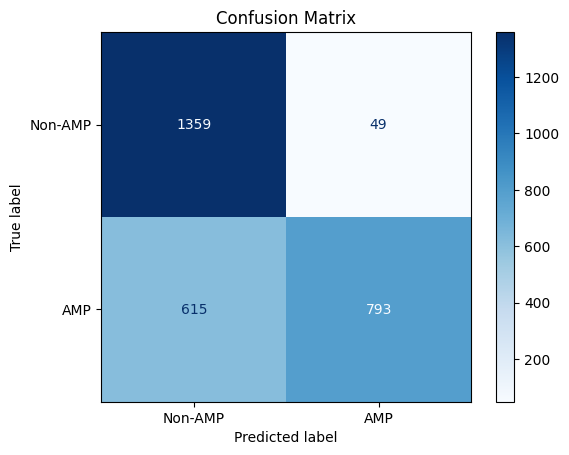

In [19]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
mcc = matthews_corrcoef(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_probabilities)

metrics = {
    "accuracy": accuracy,
    "f1": f1,
    "mcc": mcc,
    "precision": precision,
    "recall": recall,
    "roc_auc": roc_auc,
}

print("Metrics:")
from pprint import pprint
pprint(metrics)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-AMP", "AMP"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()